# Streetscapes workspaces

This notebook illustrates how to use project workspaces in Streetscapes. You can load different data sources and ML models, process streetview images and save generated data to your workspace.

This notebook includes the following steps:

- [Define a workspace](#1---define-a-workspace)
- [Subset data](#2---subset-data)
- [Visualise data](#3---visualise-data)
- [Download images](#4---download-images)
- [Segment images](#5---segment-images)
- [Calculate statistics](#6---calculate-statistics)
- [Rasterise data](#7---rasterise-data)

### 0 - Libraries

In [1]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import ibis

ibis.options.interactive = True

# --------------------------------------
from streetscapes.models import ModelType
from streetscapes.sources import SourceType
from streetscapes.streetview import SVWorkspace

### 1 - Define a workspace

Streetscapes has a workspace functionality to facilitate data analysis. Within this workspace, downloaded data, images, segmented masks and analysis for a certain project are self contained and reproducible. 

<span style="color:grey;"><i> Note: You can also pass the path to an `.env` file containing configuration options for the workspace. By default, the workspace looks for an `.env` file inside the workspace directory, and if it doesn't exist, it walks the parent tree until it finds one or it reaches the root of the file system. Environment variables are also recognised automatically.</i></span>

First, create a workspace or load an existing one. In this tutorial, we will be doing an analysis of Amsterdam, so we are naming our workspace "Amsterdam":

In [2]:
ws = SVWorkspace("./Amsterdam", create=True)

Let's now look at where this new workspace is located:

In [3]:
workspace_path = ws.get_workspace_path("")
workspace_path

PosixPath('/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorial/Amsterdam')

Now let's add which source of images we would like to use. Possible are sources are: [Mapillary](https://www.mapillary.com/), [Kartaview](https://kartaview.org/), [Google Streetview](https://developers.google.com/maps/documentation/streetview) and [Amsterdam Open Panorama](https://amsterdam.github.io/projects/open-panorama/). It is also possible to use [Global Streetscapes](https://ual.sg/project/global-streetscapes/) as a data source. 

In this example, we will use Global Streetscapes, Kartaview and Mapillary. 

<span style="color:red;">NOTE</span>: Make sure you have the appropriate API keys stored in your `.env` file. 

In [4]:
mp = ws.add_source(SourceType.Mapillary)

We can then view where these data sources are located. This will be where all images, instances and masks will be stored. 

In [5]:
mp

MapillarySource(root_dir='~/.cache/huggingface/assets/streetscapes/images/mapillary')

If we show the contents of the workspace directory, we can see that a subdirectory for Amsterdam was created as well as a [duckdb](https://duckdb.org/) metadata file.

In [6]:
ws.show_contents()

Amsterdam/
├─metadata.db
└─subsets/
  └─amsterdam.parquet


To test that the connection to our data sources work, we can get the image URLs for a KartaView and a Mapillary image:

In [7]:
mp_img_url = mp.get_image_url("4911230068985425")
mp_img_url

'https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/An--rrF4WlM05JH5SMiWxbdSXVWL0mFEymquJWW0EmSjaBemmKBcF8DRGqIe8akNayRiH0VTYunIfeHZlt2zAGA0sYkEkeWIUtnfp27cgiCen37fra1_v0gwTJFgNL5wTiUGkS7F56f_yLBZF1HqZg?edm=ALXxkZ8EAAAA&_nc_gid=xoO4o5fLsuyK2TRFnsVosw&_nc_oc=AdlLWq6SzSf1M-jZKBxoOoVEyU3X9YwZhLlEnbppO3A3w6rIbFdRkCcuM0bXDaiL9-o&ccb=10-5&oh=00_AfEbIPQD_7Ar6SLnXw8X8EQ7AbybdBf5h-ySeAaDuOI97Q&oe=68382FBC&_nc_sid=201bca'

### 2 - Subset data

Let's have a more detailed look into the data sources that we have loaded. Choose a bounding box for the area you would like to download images for and fetch the image ids from Mapillary.

In [8]:
bbox = [4.883466,52.361790,4.916210,52.381494]
df = mp.fetch_image_ids(bbox=bbox)
df

id   altitude  atomic_scale      camera_type  \
0    1649233568877820  97.717000      1.059452          fisheye   
1    1440440573421267  47.473000      0.922452          fisheye   
2    1653351585111997  57.736000      1.021121          fisheye   
3    2926895354296774  48.299263      1.004291  equirectangular   
4    2807034466269710  41.991000      1.118863      perspective   
..                ...        ...           ...              ...   
480  2751015888492878   1.341335      1.001925      perspective   
481  1510169696468656  53.824000      0.901977          fisheye   
482  2684980568356057  41.838000      1.005428          fisheye   
483  5031563493565288  43.559000      0.697338      perspective   
484  3955872977814732  48.108846      0.999278  equirectangular   

       captured_at  compass_angle  computed_altitude  computed_compass_angle  \
0    1683374536000     304.621955           1.425104               35.430415   
1    1683740732000      18.265245           2.131885               24.674998   
2    1683207854000      99.989515           0.749752              125.469560   
3    1471239614387       0.000000           1.824661              359.886893   
4    1651577739333     355.014809           2.337936              175.183040   
..             ...            ...                ...                     ...   
480  1472556944616     357.110200           1.935072               34.151400   
481  1687883344000     194.111000           2.131648              179.581830   
482  1725003808000      43.654000           2.622776               54.789884   
483  1651577100329     334.602489           1.292805              283.489237   
484  1490616532412       0.000000           2.042463                0.102751   

                                     computed_geometry  \
0    {'type': 'Point', 'coordinates': [4.8964892314...   
1    {'type': 'Point', 'coordinates': [4.8963813629...   
2    {'type': 'Point', 'coordinates': [4.8903723500...   
3    {'type': 'Point', 'coordinates': [4.8908900414...   
4    {'type': 'Point', 'coordinates': [4.8897936792...   
..                                                 ...   
480  {'type': 'Point', 'coordinates': [4.9003805707...   
481  {'type': 'Point', 'coordinates': [4.8892299950...   
482  {'type': 'Point', 'coordinates': [4.8958258749...   
483  {'type': 'Point', 'coordinates': [4.8922216090...   
484  {'type': 'Point', 'coordinates': [4.8920564451...   

                                     computed_rotation  ...     make  \
0    [1.5326298231132, -0.53097772307454, 0.4408192...  ...    GoPro   
1    [1.4574277165684, -0.24508056480347, 0.4295415...  ...    GoPro   
2    [0.67019888230282, -1.602978159796, 1.58177652...  ...    GoPro   
3    [1.5816287170869, -0.00021432401726609, -0.003...  ...  Trimble   
4    [0.075550719835549, -2.2431224563807, 2.098630...  ...    GoPro   
..                                                 ...  ...      ...   
480  [1.5179624759416, -0.42675876122432, 0.5071911...  ...    Apple   
481  [-0.044992941243972, 2.0492082251223, -2.35159...  ...    GoPro   
482  [1.4332586456774, -0.50152578133045, 1.0080608...  ...    GoPro   
483  [1.3366288188521, 1.0847114812961, -0.99153612...  ...    GoPro   
484  [1.577875090716, -0.0024258049843389, 0.000401...  ...  Trimble   

           model                                      thumb_256_url  \
0    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
1    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
2    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
3    Trimble TMX  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
4    HERO9 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
..           ...                                                ...   
480    iPhone6,2  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
481  HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
482  HERO7 Black  https://scontent-ams4-1.xx.fbcdn.n

### 3 - Visualise Data

Now that we have subsetted the data, we might want to see where the images we want to download are located and if we have good coverage of the city. 

First, the table needs to be converted to a geopandas dataframe and given an appropriate CRS. 

In [9]:
import geopandas as gpd
import contextily

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

id   altitude  atomic_scale      camera_type  \
0    1649233568877820  97.717000      1.059452          fisheye   
1    1440440573421267  47.473000      0.922452          fisheye   
2    1653351585111997  57.736000      1.021121          fisheye   
3    2926895354296774  48.299263      1.004291  equirectangular   
4    2807034466269710  41.991000      1.118863      perspective   
..                ...        ...           ...              ...   
480  2751015888492878   1.341335      1.001925      perspective   
481  1510169696468656  53.824000      0.901977          fisheye   
482  2684980568356057  41.838000      1.005428          fisheye   
483  5031563493565288  43.559000      0.697338      perspective   
484  3955872977814732  48.108846      0.999278  equirectangular   

       captured_at  compass_angle  computed_altitude  computed_compass_angle  \
0    1683374536000     304.621955           1.425104               35.430415   
1    1683740732000      18.265245           2.131885               24.674998   
2    1683207854000      99.989515           0.749752              125.469560   
3    1471239614387       0.000000           1.824661              359.886893   
4    1651577739333     355.014809           2.337936              175.183040   
..             ...            ...                ...                     ...   
480  1472556944616     357.110200           1.935072               34.151400   
481  1687883344000     194.111000           2.131648              179.581830   
482  1725003808000      43.654000           2.622776               54.789884   
483  1651577100329     334.602489           1.292805              283.489237   
484  1490616532412       0.000000           2.042463                0.102751   

                                     computed_geometry  \
0    {'type': 'Point', 'coordinates': [4.8964892314...   
1    {'type': 'Point', 'coordinates': [4.8963813629...   
2    {'type': 'Point', 'coordinates': [4.8903723500...   
3    {'type': 'Point', 'coordinates': [4.8908900414...   
4    {'type': 'Point', 'coordinates': [4.8897936792...   
..                                                 ...   
480  {'type': 'Point', 'coordinates': [4.9003805707...   
481  {'type': 'Point', 'coordinates': [4.8892299950...   
482  {'type': 'Point', 'coordinates': [4.8958258749...   
483  {'type': 'Point', 'coordinates': [4.8922216090...   
484  {'type': 'Point', 'coordinates': [4.8920564451...   

                                     computed_rotation  ...     make  \
0    [1.5326298231132, -0.53097772307454, 0.4408192...  ...    GoPro   
1    [1.4574277165684, -0.24508056480347, 0.4295415...  ...    GoPro   
2    [0.67019888230282, -1.602978159796, 1.58177652...  ...    GoPro   
3    [1.5816287170869, -0.00021432401726609, -0.003...  ...  Trimble   
4    [0.075550719835549, -2.2431224563807, 2.098630...  ...    GoPro   
..                                                 ...  ...      ...   
480  [1.5179624759416, -0.42675876122432, 0.5071911...  ...    Apple   
481  [-0.044992941243972, 2.0492082251223, -2.35159...  ...    GoPro   
482  [1.4332586456774, -0.50152578133045, 1.0080608...  ...    GoPro   
483  [1.3366288188521, 1.0847114812961, -0.99153612...  ...    GoPro   
484  [1.577875090716, -0.0024258049843389, 0.000401...  ...  Trimble   

           model                                      thumb_256_url  \
0    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
1    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
2    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
3    Trimble TMX  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
4    HERO9 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
..           ...                                                ...   
480    iPhone6,2  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
481  HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
482  HERO7 Black  https://scontent-ams4-1.xx.fbcdn.n

Then we can plot the image locations:

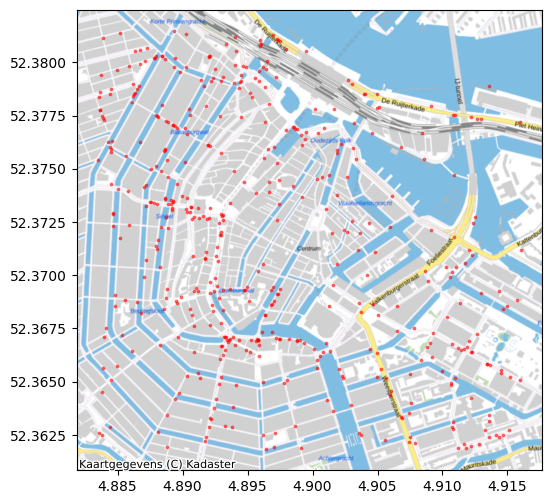

In [10]:
ax = gdf.plot(column='uuid', color='red', markersize=3, figsize=(6, 6), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)

### 4 - Download images

Let's first download a single image: 

In [11]:
import requests

def download_image(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

image = gdf.iloc[0]
filename = mp.root_dir / (image.id + '.png')
url = image.thumb_2048_url
download_image(url, filename)

Now let's do this for the first 10 images of our dataset: 

In [12]:
df_sample = df.iloc[:10]
for i, image in df_sample.iterrows():
    filename = mp.root_dir / (image["id"] + '.jpeg')
    url = image.thumb_2048_url
    download_image(url, filename)

# Getting around the segmentation function requirements
# TODO: Fix needing to do this
df_sample["source"] = 'mapillary'
df_sample["image_id"] = df_sample["id"]

In [13]:
# TODO: Accept something other than an ibis table
sample = ibis.memtable(df_sample)
sample

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ id               ┃ altitude  ┃ atomic_scale ┃ camera_type     ┃ captured_at   ┃ compass_angle ┃ computed_altitude ┃ computed_compass_angle ┃ computed_geometry                                 ┃ computed_rotation                               ┃ exif_orientation ┃ geometry                                          ┃ height ┃ is_pano ┃ make    ┃ model         ┃ thumb_256_url                                                                    ┃ thumb_1024_url                                                                   ┃ thumb_2048_url                                                                   ┃ thumb_original_url                                                               ┃ sequence               ┃ width ┃ latitude  ┃ longitude ┃ source    ┃ image_id         ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ string           │ float64   │ float64      │ string          │ int64         │ float64       │ float64           │ float64                │ struct<coordinates: array<float64>, type: string> │ array<float64>                                  │ int64            │ struct<coordinates: array<float64>, type: string> │ int64  │ boolean │ string  │ string        │ string                                                                           │ string                                                                           │ string                                                                           │ string                                                                           │ string                 │ int64 │ float64   │ float64   │ string    │ string           │
├──────────────────┼───────────┼──────────────┼─────────────────┼───────────────┼───────────────┼───────────────────┼────────────────────────┼───────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────────┼───────────────────────────────────────────────────┼────────┼─────────┼─────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼───────┼───────────┼───────────┼───────────┼──────────────────┤
│ 1649233568877820 │ 97.717000 │     1.059452 │ fisheye         │ 1683374536000 │    304.621955

In [14]:
ws.get_workspace_path("")

PosixPath('/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorial/Amsterdam')

### 5 - Segment images

We can load various models and apply them to the image data that we have loaded or generated so far. Currently, Streetscapes supports two segmentation models:

- `MaskFormer`: A relatively small and nimble model that recognises objects from a fixed number of categories.
- `DinoSAM`: A combination of two independent models that work together to perform instance segmentation simply by providing a prompt. It is much more flexible than `MaskFormer` in that it recognises *arbitrary categories*; however, it is much slower.

We will segment the images with both models to illustrate their differences. First, we load the models using an API analogous to that for data sources, with the exception that models are spawned globally and can be reused across multiple workspaces since they are workspace-agnostic. This is another design choice to minimise memory consumption for potentially large models.

In [15]:
mf = ws.spawn_model(ModelType.MaskFormer)
ds = ws.spawn_model(ModelType.DinoSAM)

We define the categories of objects that we would like to look for in the images that we are segmenting. Categories are defined hierarchically as a nested dictionary. Subcategories (such as `window` and `door` below) will be identified as separate categories, but the pixels that they occupy will be subtracted from ones attributed to their parent (here, `building`). In this way, it is possible to extract building façades excluding windows and doors. Internally, this nested dictionary is flattened, and any overlaps are handled after instances of the corresponding categories have been identified.

In [16]:
labels = {
    "building": {
        "window": None,
        "door": None,
    },
    "vegetation": None,
    "car": None,
    "truck": None,
    "road": None,
}

Segment all images contained in a dataset. Here, we use our`sample` dataset that we created above. A batch size (defaulting to `10`) can be specified to speed up the segmentation, but here we use a batch size of 1 to show the progress more clearly.

In [17]:
#TODO: Make this function more flexible so columns names can be set
#TODO: Don't require a source and don't assume path to images? 
mf_segmentations = ws.segment_from_dataset(sample, mf, labels)

Streetscapes | 2025-04-29@15:54:22 | Reusing an existing Mapillary source, use the replace argument to override.
Done: 100%|██████████| 2/2 [00:18<00:00,  9.26s/it]                          


The masks and the instances are saved as separate files with the same name as the input image but in different formats (NumPy archived arrays and Parquet files, respectively) so that they can be loaded later together. Here, we print the name of the file containing the mask for the first segmented image.

In [18]:
mf_segmentations[0].mask_path.name

'3040377542937028.npz'

Show the categories (out of the ones that we requested) identified by this model.

In [19]:
mf_segmentations[0].get_instance_table().select('label').distinct()

┏━━━━━━━━━━━━┓
┃ label      ┃
┡━━━━━━━━━━━━┩
│ string     │
├────────────┤
│ bicycle    │
│ road       │
│ vegetation │
│ car        │
│ terrain    │
│ building   │
│ pole       │
│ sidewalk   │
│ curb       │
│ sky        │
│ …          │
└────────────┘

Visualise the parts of the image corresponding to some object categories of interest (here, we ask for everything that is labelled as a `building`).

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

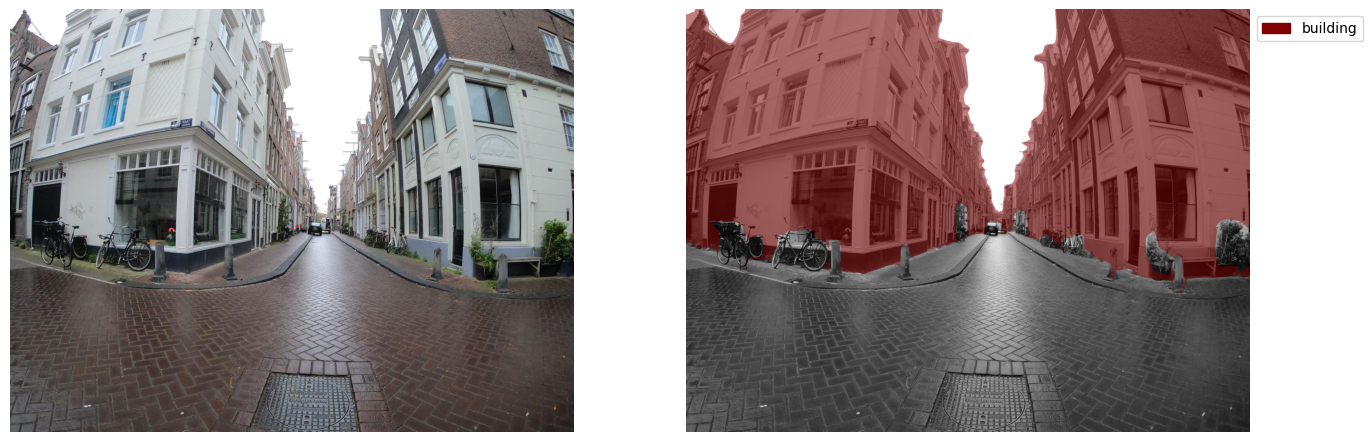

In [20]:
mf_segmentations[0].visualise('building')

If the `visualise()` method is called without an argument, all the identified categories are visualised.

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

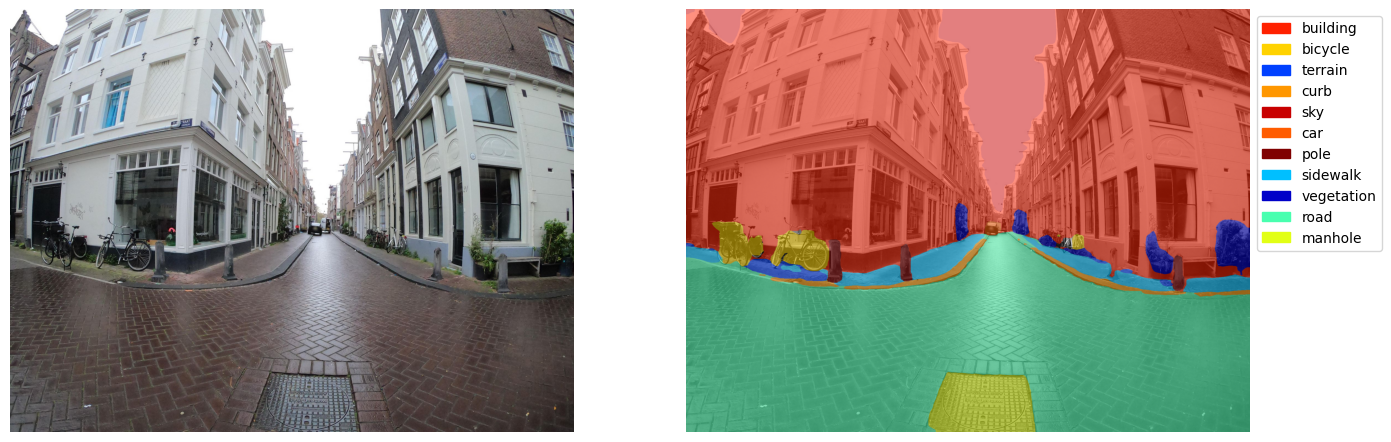

In [21]:
mf_segmentations[0].visualise()

We can also extract instances for individual categories and and visualise them in isolation.

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

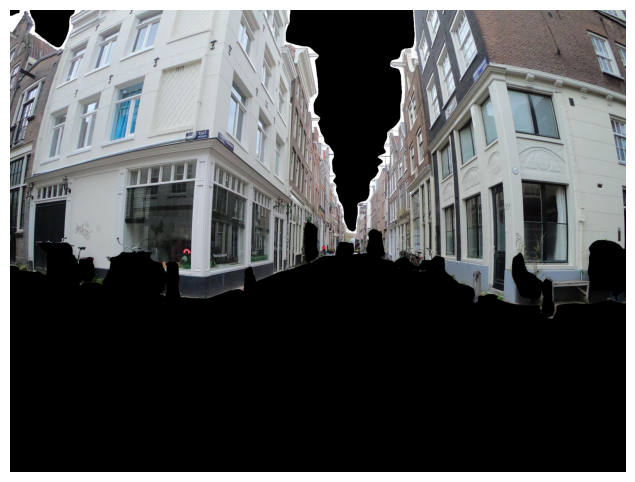

In [22]:
buildings = mf_segmentations[0].get_instances("building")
buildings[0].visualise(mf_segmentations[0].get_image())

We will now execute the same pipeline with the `DinoSAM` model.

In [23]:
ds_segmentations = ws.segment_from_dataset(sample, ds, labels, batch_size=1)

Streetscapes | 2025-04-29@15:54:42 | Reusing an existing Mapillary source, use the replace argument to override.
Done: 100%|██████████| 11/11 [01:17<00:00,  7.06s/it]                          


In [24]:
ds_segmentations[0].get_instance_table().select('label').distinct()

┏━━━━━━━━━━━━┓
┃ label      ┃
┡━━━━━━━━━━━━┩
│ string     │
├────────────┤
│ truck      │
│ road       │
│ car        │
│ window     │
│ building   │
│ vegetation │
│ door       │
└────────────┘

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

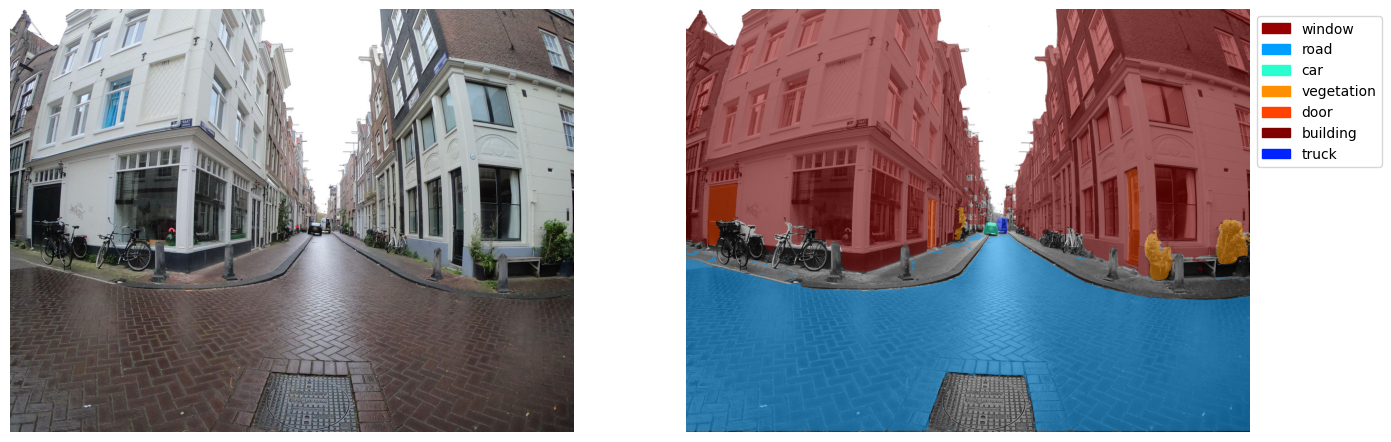

In [25]:
ds_segmentations[0].visualise()

In [26]:
ds_segmentations[0]

Segmentation(mask=/Users/clairedonnelly/.cache/huggingface/assets/streetscapes/images/mapillary/masks/dinosam/3040377542937028.npz

### 6 - Calculate statistics

In [27]:
import numpy as np

image_means = []
for seg in ds_segmentations:
    image = seg.get_image()
    buildings = seg.get_instances("building")
    building_means = []
    for building in buildings:
        # TODO: would be nice to have building.get_mask_3d or something like that
        mask_3d = np.repeat(building.mask[:, :, None], 3, axis=2)
        masked_img = np.ma.masked_array(image, mask=mask_3d)
        building_mean = masked_img.mean()
        building_means.append(building_mean)
    image_mean = np.mean(building_means)
    image_means.append(image_mean)

np.array(image_means)


array([119.94659754, 128.02359361,  94.80119688,  95.04374195,
       130.25558678, 135.22156036, 128.02359361,  88.94505537,
        99.20946164,  83.05246076,  81.57099191])

In [28]:
# # Wishful code for calculation means

# image_means = []
# for seg in ds_segmentations:
#     image = seg.get_image()
#     buildings = seg.get_instances("building")
#     # TODO: would be nice if we had a utility to directly calculate something on all instances at once
#     building_means = [building.mask_3d.mean() for building in buildings]
#     image_mean = np.mean(building_means)
#     image_means.append(image_mean)

# # Even more streamlined version
# pixel_mean = lambda pixels: pixels.mean
# image_means = [seg.get_all_instances("building").apply(pixel_mean) for seg in ds_segmentations]

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

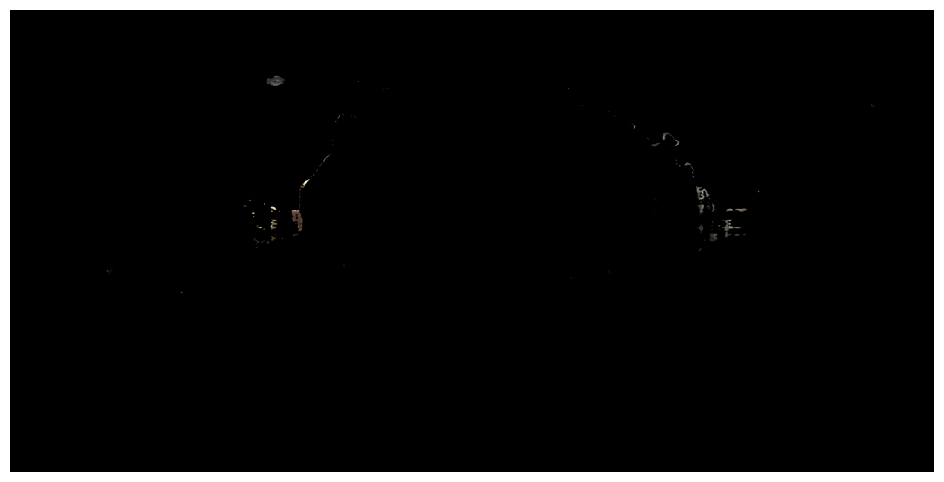

In [29]:
buildings[0].visualise(image)

### 7 - Rasterise data

Here we will use the geopandas dataframe we created early to create a raster. 

To rasterise points, you first need to create a template raster with the same extents and CRS as your input point data. 

In [37]:
gss = ws.add_source(SourceType.GlobalStreetscapes)
streetscapes = gss.load_parquet("streetscapes")
ams = streetscapes.filter(streetscapes["city"] == "Amsterdam")
ams_df = ams.to_pandas()


Streetscapes | 2025-04-29@15:58:48 | Reusing an existing GlobalStreetscapes source, use the replace argument to override.


In [38]:
ams_gdf = gpd.GeoDataFrame(ams_df, geometry=gpd.points_from_xy(ams_df.lon, ams_df.lat))
ams_gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

uuid     source           orig_id  \
0      840d52d5-1bbe-4f77-ac5a-5d8905dca06e  Mapillary  2585835221712723   
1      6a81f09d-24b9-4179-8eb5-9cd2e91c13d9  Mapillary  4130433687048823   
2      26c37fae-3485-4ca1-8b97-9f449a8da680  Mapillary   219442182852752   
3      b8ae9b6a-deb3-4e85-a6e9-75c03f77573e  Mapillary  4077211285668521   
4      792266c8-eb57-4730-ba26-6dd3551a7b60  Mapillary  3299296920297092   
...                                     ...        ...               ...   
25945  40a57de0-e318-4223-9eec-aed0d206626b  Mapillary   814021062828141   
25946  558c33a4-0683-48dc-b65c-5e363131c96a  Mapillary   311514900377965   
25947  19ae2fd5-6bd9-4c7f-803d-0fbb60eb57be  Mapillary   483304176202009   
25948  4dbe1508-9ed0-4f47-9fa9-a43d92b00177  Mapillary   154729933270080   
25949  8e42c30d-b60b-4506-a9bb-63e0b60188bd  Mapillary  3998516656896471   

       glare lighting_condition  pano_status         platform        quality  \
0      False                day         True  driving surface  slightly poor   
1      False                day        False  walking surface           good   
2      False                day        False  walking surface  slightly poor   
3      False                day        False  walking surface           good   
4      False          dusk/dawn        False  walking surface           good   
...      ...                ...          ...              ...            ...   
25945  False                day         True  driving surface  slightly poor   
25946  False                day         True  cycling surface           good   
25947  False                day        False  walking surface           good   
25948  False                day        False  walking surface           good   
25949  False                day         True  driving surface           good   

       reflection view_direction  ...   ref          tunnel_1  bridge_1  \
0           False           None  ...  None              None      None   
1           False           side  ...  None              None      None   
2           False     front/back  ...  None              None       yes   
3           False     front/back  ...  None  building_passage      None   
4           False     front/back  ...  None              None      None   
...           ...            ...  ...   ...               ...       ...   
25945       False           None  ...  None              None      None   
25946       False           None  ...  None              None      None   
25947       False           side  ...  None              None       yes   
25948       False           side  ...  None              None      None   
25949       False           None  ...  None              None      None   

      service  access  road_width  area  est_width  reversed  \
0        None    None        None  None       None     False   
1        None    None        None  None       None     False   
2        None    None        None  None       None     False   
3        None    None        None  None       None     False   
4        None    None        None  None       None     False   
...       ...     ...         ...   ...        ...       ...   
25945    None    None        None  None       None     False   
25946    None    None         1.8  None       None     False   
25947    None    None        None  None       None     False   
25948    None    None        None  None       None      True   
25949    None    None        None  None       None     False   

                       geometry  
0      POINT (4.89688 52.36513)  
1      POINT (4.88859 52.37129)  
2      POINT (4.88688 52.36776)  
3      POINT (4.89535 52.37119)  
4      POINT (4.89978 52.37424)  
...                         ...  
25945  POINT (4.88882 52.37411)  
25946  POINT (4.89546 52.37503)  
25947  POINT (4.89559 52.37192)  
25948  POINT (4.89044 52.37333)  
25949   POINT (4.8974 52.37335)  

[25950 rows x 141 columns]

In [39]:
import rasterio
import rasterio.features as rfeatures
import rasterio.plot as rplot
import math

ams_proj = ams_gdf.to_crs(28992)

bounds = ams_proj.total_bounds
horizontal_resolution = 100
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=horizontal_resolution, 
    ysize=horizontal_resolution
)
transform

Affine(100.0, 0.0, np.float64(120311.91265181282),
       0.0, -100.0, np.float64(487646.1447921692))

Calculate output shape and create pairs of coordinates to values

In [40]:
rows = math.ceil((bounds[3] - bounds[1]) / horizontal_resolution)
cols = math.ceil((bounds[2] - bounds[0]) / horizontal_resolution)
shape = (rows, cols)

g = [(g, v) for g, v in ams_proj[['geometry', 'Beautiful']] \
        .dropna(subset='Beautiful')
        .to_numpy() \
        .tolist()]

Then, map these pairs to the template raster, which creates a rasterised dataset

In [41]:
raster = rfeatures.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
    fill=np.nan
)
raster[:1]

array([[5.35, 6.04, 3.74, 4.37, 5.4 , 6.22, 8.49, 7.43, 4.28, 6.38, 5.33,
        9.09, 3.97, 4.84, 7.54, 8.81]])

Finally, plot the point data and the rasterised data to compare

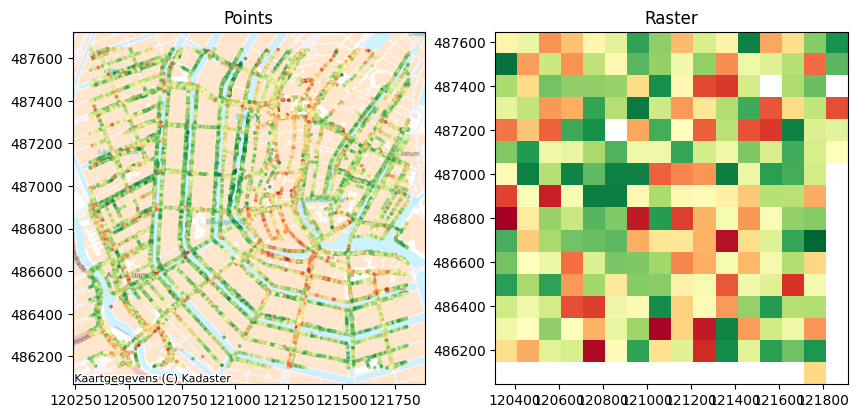

In [42]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the GeoDataFrame on the first subplot
ax = ams_proj.plot(column='Beautiful', ax=ax1, cmap='RdYlGn', markersize=3, alpha=0.5)
contextily.add_basemap(ax, crs=ams_proj.crs, source=contextily.providers.nlmaps.pastel)
ax1.set_title('Points')

# Plot the raster on the second subplot
rplot.show(raster, transform=transform, ax=ax2, cmap='RdYlGn')
ax2.set_title('Raster')

# Show the plot
plt.show()

We can also overlay the plots for easier comparison

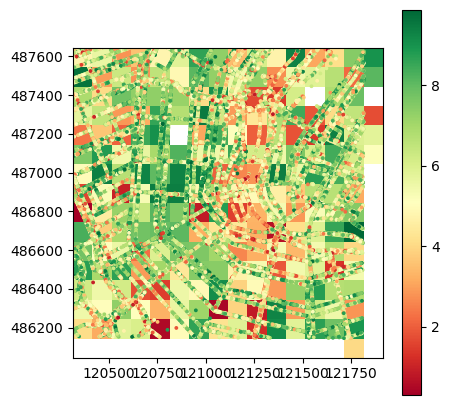

In [43]:
# Combined plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot points
ams_proj.plot(column='Beautiful', ax=ax, cmap='RdYlGn', legend=True, markersize=3)

# Plot raster
rasterio.plot.show(raster, transform=transform, ax=ax, cmap='RdYlGn')

# Show the plot
plt.show()